# **Importation des bibliothèques**





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
#from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# **Chargement du jeu de données**


In [ ]:
!wget --no-check-certificate https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
!unzip /content/smsspamcollection.zip

df = pd.read_csv("/content/SMSSpamCollection", sep='\t', header=None, names=['label', 'message'])
df.head()



--2025-05-22 22:11:35--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [         <=>        ] 198.65K  74.6KB/s    in 2.7s    

2025-05-22 22:11:38 (74.6 KB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  /content/smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# **Step 1: Data Understanding**

In [ ]:
df.shape

(5572, 2)

In [ ]:
df.columns

Index(['label', 'message'], dtype='object')

In [ ]:
df.dtypes

,0
label,object
message,object


In [ ]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


# **Step 2: Data Preperation**

In [ ]:
# Check pour null valeurs
df.isna().sum()

,0
label,0
message,0


In [ ]:
# check for duplicated
df.loc[df.duplicated()]

,label,message
103,ham,As per your request 'Melle Melle (Oru Minnamin...
154,ham,As per your request 'Melle Melle (Oru Minnamin...
207,ham,"As I entered my cabin my PA said, '' Happy B'd..."
223,ham,"Sorry, I'll call later"
326,ham,No calls..messages..missed calls
...,...,...
5524,spam,You are awarded a SiPix Digital Camera! call 0...
5535,ham,"I know you are thinkin malaria. But relax, chi..."
5539,ham,Just sleeping..and surfing
5553,ham,Hahaha..use your brain dear


remove duplicated (not now)

In [ ]:
  # df = df.loc[~df.duplicated()] \
  #   .reset_index(drop=True).copy

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5164,spam,This is the 2nd time we have tried 2 contact u...
5165,ham,Will ü b going to esplanade fr home?
5166,ham,"Pity, * was in mood for that. So...any other s..."
5167,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# total sms avec duplicates
total_sms = len(df)
print(f"nombre totale sms est : {total_sms}")
# creation de duplicates_df
duplicates_df = df.loc[df.duplicated()].reset_index(drop=True).copy()

# Total nombre duplicates
duplicates_count = len(duplicates_df)
print(f"nombre total de dupplicates est : {duplicates_count}")

# percentage  duplicates

duplicate_percentages = round((duplicates_count*100)/total_sms)


# Duplicates par label
duplicated_by_label = duplicates_df['label'].value_counts()
print(f"Les doublons par label :\n{duplicated_by_label}")

# Verification totale spam duplicates
total_spam_dup = len(duplicates_df[duplicates_df['label'] == 'spam'])
# print(f"total ham est : {total_spam_dup}")



# Verification total ham duplicates
total_ham_dup = len(duplicates_df[duplicates_df['label'] == 'ham'])
# print(f"total spam est : {total_ham_dup}")


# Percentage  duplicates pour ham
duplicate_percentages_ham = round(((total_ham_dup*100) / duplicates_count ),2)
print(f"\nPourcentage de doublons par label ham (%) :\n{duplicate_percentages_ham}")

# Percentage  duplicates pour  spam
duplicate_percentages_spam = round(((total_spam_dup*100) / duplicates_count ),2)
print(f"\nPourcentage de doublons par label spam (%) :\n{duplicate_percentages_spam}")

t_duplicate_percentage = round((duplicate_percentages_ham + duplicate_percentages_spam) ,2)
print(f"Pourcentage total de doublons  'ham + spam (%)' : {t_duplicate_percentage}")


nombre totale sms est : 5572
nombre total de dupplicates est : 403
Les doublons par label :
label
ham     309
spam     94
Name: count, dtype: int64

Pourcentage de doublons par label ham (%) :
76.67

Pourcentage de doublons par label spam (%) :
23.33
Pourcentage total de doublons  'ham + spam (%)' : 100.0


# **Step 3: Feature Understanding**

In [ ]:
df[["message","label"]].value_counts()

,,count
message,label,
"Sorry, I'll call later",ham,30
I cant pick the phone right now. Pls send a message,ham,12
Ok...,ham,10
Ok.,ham,4
Please call our customer service representative on FREEPHONE 0808 145 4742 between 9am-11pm as you have WON a guaranteed £1000 cash or £5000 prize!,spam,4
...,...,...
"I can probably come by, everybody's done around &lt;#&gt; right?",ham,1
I can make lasagna for you... vodka...,ham,1
"I can make it up there, squeezed &lt;#&gt; bucks out of my dad",ham,1


In [ ]:

#  Visualisation de la distribution des classes
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Distribution des Classes (Ham vs Spam)')
plt.xlabel('Classe')
plt.ylabel('Nombre de Messages')
plt.savefig('class_distribution.png')
plt.close()

In [ ]:
ax_message = df['message'].value_counts().head(10).plot(kind='barh',title='Message Distribution')
ax_message.set_xlabel('Count')
ax_message.set_ylabel('Message')
plt.savefig('top_message_distribution.png')
plt.close()

In [ ]:
#  Analyse de la longueur des messages
# df['message_length'] = df['message'].apply(len)
message_lengths = df['message'].apply(len)  # Temporielle series
plt.figure(figsize=(8, 5))
# sns.histplot(data=df, x='message_length', hue='label', bins=50, kde=True)
sns.histplot(x=message_lengths, hue=df['label'], bins=50, kde=True)
plt.title('Distribution de la Longueur des Messages par Classe')
plt.xlabel('Longueur du Message (caractères)')
plt.ylabel('Nombre de Messages')
plt.savefig('message_length_distribution.png')
plt.close()

In [ ]:
#  Mots les plus fréquents par classe
def get_top_n_words(messages, n=20):
    all_words = ' '.join(messages).lower().split()
    word_freq = pd.Series(all_words).value_counts()
    return word_freq.head(n)


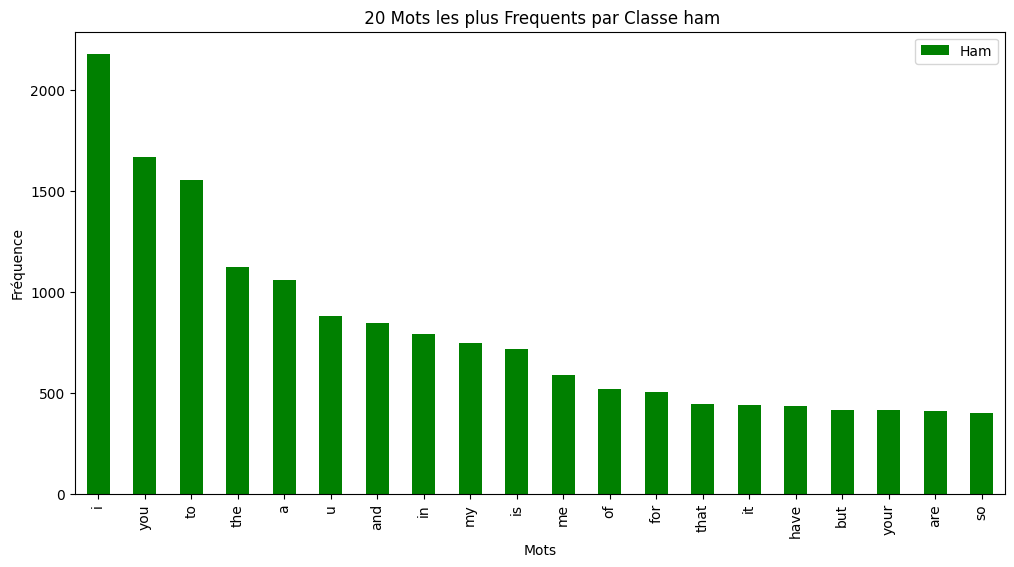

In [ ]:
# Top 10 mots pour ham
top_10_words_ham = get_top_n_words(df[df['label'] == 'ham']['message'], n=20)
# plot top ham classe mots
plt.figure(figsize=(12, 6))
top_10_words_ham.plot(kind='bar', label='Ham', color='green')
plt.title(' 20 Mots les plus Frequents par Classe ham')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.legend()
plt.show()
plt.savefig('top_ham_words_distribution.png')
plt.close()


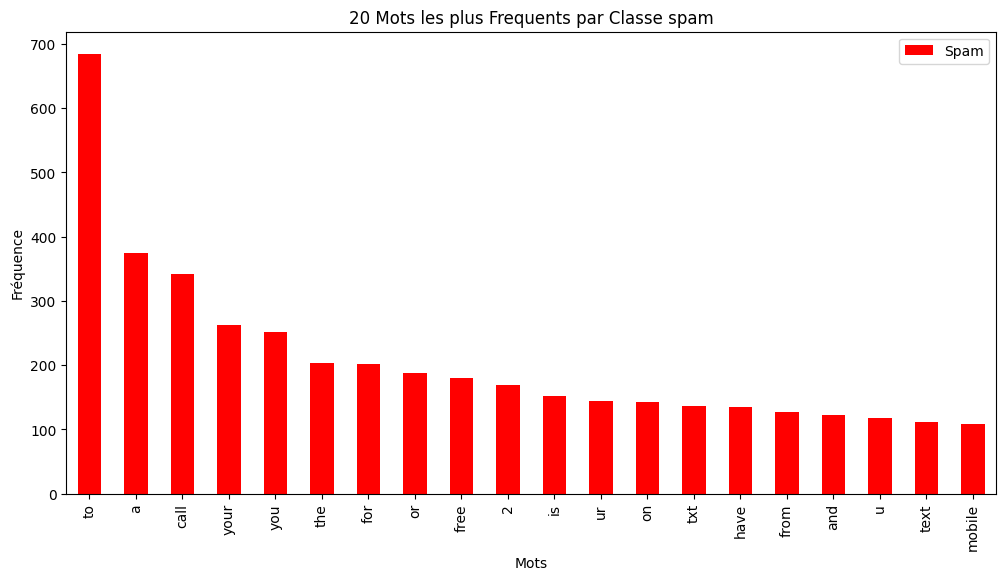

In [ ]:
# Top 10 mots pour spam
top_10_words_spam = get_top_n_words(df[df['label'] == 'spam']['message'], n=20)
# plot top 10 mots spam
plt.figure(figsize=(12, 6))
top_10_words_spam.plot(kind='bar', label='Spam', color='red')
plt.title('20 Mots les plus Frequents par Classe spam')
plt.xlabel('Mots')
plt.ylabel('Fréquence')
plt.legend()
plt.show()
plt.savefig('top_spam_motss_distribution.png')
plt.close()



In [ ]:
df.columns

Index(['label', 'message'], dtype='object')

L'étape suivante consiste à préparer le jeu de données pour construire un modèle. Un modèle de machine learning ne peut traiter que des nombres, donc nous devons convertir notre texte en nombres à l'aide du **TfidfVectorizer**.

Tout d'abord, nous allons diviser le jeu de données en un ensemble d'entraînement (train ) et un ensemble de test (test ).
Pour l'ensemble d'entraînement, nous prendrons **80 %** des données du jeu de données, et nous les utiliserons pour entraîner le modèle.
Le reste du jeu de données (**20 %**) sera utilisé pour tester le modèle.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size = 0.2, random_state = 42)


Une fois que nous avons divisé nos données, nous pouvons utiliser le TfidfVectorizer.
Cela nous renverra une matrice creuse (sparse matrix), c’est-à-dire une matrice contenant principalement des zéros.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
tfs = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [ ]:
# Inspect TF-IDF features
feature_names = vectorizer.get_feature_names_out()
tfid_df = pd.DataFrame(tfs.T.todense(), index=feature_names)
print(tfid_df[1200:1205])

        0     1         2     3        4     5     6     7     8     9     \
giving   0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
glad     0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
gm       0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
gn       0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
go       0.0   0.0  0.272403   0.0  0.13167   0.0   0.0   0.0   0.0   0.0   

        ...  4447  4448  4449      4450  4451  4452  4453  4454  4455  4456  
giving  ...   0.0   0.0   0.0  0.260605   0.0   0.0   0.0   0.0   0.0   0.0  
glad    ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
gm      ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
gn      ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
go      ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 4457 columns]


Ensuite, nous allons entraîner un modèle en utilisant le classificateur **Naive Bayes gaussien** de scikit-learn. C’est un bon algorithme de départ pour la classification de textes. Nous afficherons ensuite la précision (**accuracy**) du modèle sur l’ensemble d’entraînement ainsi que la matrice de confusion.

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

clf = GaussianNB()
clf.fit(tfs.toarray(), y_train)


GaussianNB()

In [ ]:

y_true, y_pred = y_test, clf.predict(X_test.toarray())
accuracy_score(y_true, y_pred)

0.874439461883408

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         ham       0.98      0.87      0.92       966
        spam       0.52      0.91      0.66       149

    accuracy                           0.87      1115
   macro avg       0.75      0.89      0.79      1115
weighted avg       0.92      0.87      0.89      1115



# **Confusing matrix**

In [ ]:
cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=['ham', 'spam']),
    index=['ham', 'spam'],
    columns=['ham', 'spam']
)
print(cmtx)

      ham  spam
ham   839   127
spam   13   136


essayer avec **GridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
parameters = {"alpha": [0.1, 0.5, 1.0, 2.0]}
gs_clf = GridSearchCV(MultinomialNB(), parameters, cv=5, scoring='accuracy')
gs_clf.fit(tfs, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.5, 1.0, 2.0]}, scoring='accuracy')

In [ ]:
gs_clf.best_params_

{'alpha': 0.1}

In [ ]:
y_true, y_pred = y_test, gs_clf.predict(X_test.toarray())
accuracy_score(y_true, y_pred)

0.9874439461883409

In [ ]:
cmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred, labels=['ham', 'spam']),
    index=['ham', 'spam'],
    columns=['ham', 'spam']
)
print(cmtx)

      ham  spam
ham   965     1
spam   13   136


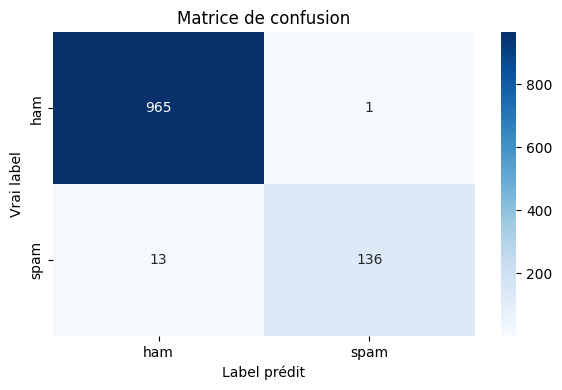

In [ ]:
# Affichage graphique
plt.figure(figsize=(6, 4))
sns.heatmap(cmtx, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.ylabel("Vrai label")
plt.xlabel("Label prédit")
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
message = vectorizer.transform(["i study in universty of nkc"])
message = message.toarray()
gs_clf.predict(message)

array(['ham'], dtype='<U4')

In [ ]:
message = vectorizer.transform(["send me your password "])
message = message.toarray()
gs_clf.predict(message)

array(['spam'], dtype='<U4')

In [ ]:
message = vectorizer.transform(["السلام "])
message = message.toarray()
gs_clf.predict(message)

array(['spam'], dtype='<U4')

# Traducation text  anglais avant predication

In [48]:
!pip install deep_translator
from deep_translator import GoogleTranslator
from sklearn.feature_extraction.text import TfidfVectorizer

arabic_message = " لقد فزتم معنا بجائزة، اضغط على هذا الرابط"
translated_message = GoogleTranslator( target='en').translate(arabic_message)


In [47]:
print(f"Translated message: {translated_message}")
# Vectorization message apres la traducation
message = vectorizer.transform([translated_message])

# Predict
prediction = gs_clf.predict(message)
print(f" message : {translated_message} =====>> Prediction: {prediction[0]} ")



Translated message: I won a prize with us, click this link
 message : I won a prize with us, click this link =====>> Prediction: spam 


# **LogisticRegression Model**

In [49]:
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)
# Convertion labels a binaire (0 pour ham, 1 pour spam)
y_train = y_train.map({'ham': 0, 'spam': 1})
y_test = y_test.map({'ham': 0, 'spam': 1})

In [50]:
# Vectorization text
vectorizer = TfidfVectorizer(max_features=3000)
tfs = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# Optional: Inspect TF-IDF
feature_names = vectorizer.get_feature_names_out()
tfid_df = pd.DataFrame(tfs.T.todense(), index=feature_names)
print(tfid_df[1200:1205])

        0     1         2     3        4     5     6     7     8     9     \
giving   0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
glad     0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
gm       0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
gn       0.0   0.0  0.000000   0.0  0.00000   0.0   0.0   0.0   0.0   0.0   
go       0.0   0.0  0.272403   0.0  0.13167   0.0   0.0   0.0   0.0   0.0   

        ...  4447  4448  4449      4450  4451  4452  4453  4454  4455  4456  
giving  ...   0.0   0.0   0.0  0.260605   0.0   0.0   0.0   0.0   0.0   0.0  
glad    ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
gm      ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
gn      ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  
go      ...   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 4457 columns]


In [53]:
# Train Logistique Regression modele
clf = LogisticRegression(max_iter=3000)
clf.fit(tfs, y_train)

LogisticRegression(max_iter=3000)

In [54]:
# predications
y_pred = clf.predict(X_test_transformed)

# evaluation model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9776

Classification Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.99       966
        Spam       1.00      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Confusion Matrix:
[[966   0]
 [ 25 124]]


In [55]:
# Optional: Test sur nouveau sms
new_sms = ["Win a free iPhone now! Click here!", "Hey, let's meet for lunch tomorrow."]
new_sms_translation = vectorizer.transform(new_sms)
predictions = clf.predict(new_sms_translation)
print("\nNew SMS Predictions:")
for sms, pred in zip(new_sms, predictions):
    print(f"SMS: {sms} -> {'Spam' if pred == 1 else 'Ham'}")


New SMS Predictions:
SMS: Win a free iPhone now! Click here! -> Spam
SMS: Hey, let's meet for lunch tomorrow. -> Ham


# **KNN**

In [ ]:
# supprimer les doublons maintenat


In [56]:
  df = df.loc[~df.duplicated()] \
    .reset_index(drop=True).copy

In [57]:
# Train KNN modele
clf = KNeighborsClassifier(n_neighbors=5, metric='euclidean')  # Default n_neighbors=5
clf.fit(tfs.toarray(), y_train)  # Convert to dense array for consistency with your GaussianNB code


KNeighborsClassifier(metric='euclidean')

In [58]:
#  predications
y_pred = clf.predict(X_test_transformed.toarray())

# Evaluation modele
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9283

Classification Report:
              precision    recall  f1-score   support

         Ham       0.92      1.00      0.96       966
        Spam       1.00      0.46      0.63       149

    accuracy                           0.93      1115
   macro avg       0.96      0.73      0.80      1115
weighted avg       0.93      0.93      0.92      1115


Confusion Matrix:
[[966   0]
 [ 80  69]]


In [59]:
# Optional: Test sur nouveau SMS
new_sms = ["Win  iPhone now! Click here!", "hi, let's meet for lunch tomorrow."]
new_sms_transformed = vectorizer.transform(new_sms)
predictions = clf.predict(new_sms_transformed.toarray())
print("\nNew SMS Predictions:")
for sms, pred in zip(new_sms, predictions):
    print(f"SMS: {sms} -> {'Spam' if pred == 1 else 'Ham'}")


New SMS Predictions:
SMS: Win  iPhone now! Click here! -> Ham
SMS: hi, let's meet for lunch tomorrow. -> Ham
